In [1]:
import geopandas as gpd
import plot_functions as pf
import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

# import processing_io as pio
import sys
import os
import joblib
import json

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString, box
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch_geometric.data import Data, Batch
import torch
from torch_geometric.data import Data
# import alphashape
from matplotlib.lines import Line2D

from shapely.geometry import Polygon
import alphashape
import geopandas as gpd
from shapely.geometry import LinearRing, Polygon


highway_mapping = {
    'trunk': 0, 'trunk_link': 0, 'motorway_link': 0,
    'primary': 1, 'primary_link': 1,
    'secondary': 2, 'secondary_link': 2,
    'tertiary': 3, 'tertiary_link': 3,
    'residential': 4, 'living_street': 5,
    'pedestrian': 6, 'service': 7,
    'construction': 8, 'unclassified': 9,
    'np.nan': -1
}

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

geojson_file_1 = "../../data/visualisation/gdf_pop_1pm_basecase_mean.geojson"
geojson_file_2 = "../../data/visualisation/gdf_pop_1pct_basecase_mean.geojson"
paris_inside_bvd_peripherique = "../../data/paris_inside_bvd_per/referentiel-comptages-edit.shp"

# Read the GeoJSON files into GeoDataFrames
gdf_pop_1pm = gpd.read_file(geojson_file_1)
gdf_pop_1pct = gpd.read_file(geojson_file_2)
gdf_paris_inside_bvd_per = gpd.read_file(paris_inside_bvd_peripherique)
boundary_df = alphashape.alphashape(gdf_paris_inside_bvd_per, 435).exterior[0]
linear_ring_polygon = Polygon(boundary_df)

common_links = set(gdf_pop_1pm['link']).intersection(gdf_pop_1pct['link'])

# Filter the rows in both GeoDataFrames where "link" is in the common_links set
gdf_pop_1pm_filtered = gdf_pop_1pm[gdf_pop_1pm['link'].isin(common_links)]
gdf_pop_1pct_filtered = gdf_pop_1pct[gdf_pop_1pct['link'].isin(common_links)]

gdf_pop_1pm_filtered['vol_car_times_10'] = gdf_pop_1pm_filtered['vol_car'] * 10

gdf_pop_1pct_filtered['highway_mapped'] = gdf_pop_1pct_filtered['highway'].map(highway_mapping)
gdf_pop_1pm_filtered['highway_mapped'] = gdf_pop_1pm_filtered['highway'].map(highway_mapping)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [2]:
gdf_pop_1pct_filtered.crs = "EPSG:2154"  # Assuming the original CRS is EPSG:2154
gdf_pop_1pct_filtered.to_crs("EPSG:4326", inplace=True)

gdf_pop_1pm_filtered.crs = "EPSG:2154"  # Assuming the original CRS is EPSG:2154
gdf_pop_1pm_filtered.to_crs("EPSG:4326", inplace=True)

In [3]:
gdf_pop_1pct_within_boundary = gdf_pop_1pct_filtered[gdf_pop_1pct_filtered.geometry.within(linear_ring_polygon)]
gdf_pop_1pm_within_boundary = gdf_pop_1pm_filtered[gdf_pop_1pm_filtered.geometry.within(linear_ring_polygon)]

In [5]:
def plot_combined_output(gdf_input: gpd.GeoDataFrame, 
                         column_to_plot: str, 
                         font: str = 'Times New Roman', 
                         save_it: bool = False, 
                         use_fixed_norm:bool=True, 
                         fixed_norm_max: int= 10, 
                         fixed_norm_mid_point: int = 200,
                         identifier_string: str = "base_case_1pm",
                         plot_in_box: bool =False
                         ):
    # call with known_districts if call with 0 or 1

    gdf = gdf_input.copy()
    if plot_in_box:
        gdf, x_min, y_min, x_max, y_max = filter_for_geographic_section(gdf)
    

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))    
    norm = get_norm(column_to_plot=column_to_plot, use_fixed_norm=use_fixed_norm, fixed_norm_max=fixed_norm_max, fixed_norm_mid_point = fixed_norm_mid_point, gdf=gdf)
    plot(gdf, ax, column_to_plot, norm, "highway_mapped")
    
    if plot_in_box:
        cbar = plot_within_box(font, x_min, y_min, x_max, y_max, fig, ax, norm)
    else:
        cbar = plot_without_box(font, fig, ax, norm)
    
    cbar.set_label('Car volume', fontname=font, fontsize=15)
    if save_it: 
        # identifier = "n_" + str(number_to_plot) if number_to_plot is not None else zone_to_plot
        plt.savefig("results/" + identifier_string, bbox_inches='tight')
    plt.show()

def get_norm(column_to_plot, use_fixed_norm, fixed_norm_max, fixed_norm_mid_point, gdf):
    if use_fixed_norm:
        norm = TwoSlopeNorm(vmin=0, vcenter=fixed_norm_mid_point, vmax=fixed_norm_max)
    else:
        norm = TwoSlopeNorm(vmin=gdf[column_to_plot].min(), vcenter=gdf[column_to_plot].median(), vmax=gdf[column_to_plot].max())
    return norm
    
def filter_for_geographic_section(gdf):
    x_min = gdf.total_bounds[0] + 0.05
    y_min = gdf.total_bounds[1] + 0.05
    x_max = gdf.total_bounds[2]
    y_max = gdf.total_bounds[3]
    bbox = box(x_min, y_min, x_max, y_max)

    # Filter the network to include only the data within the bounding box
    gdf = gdf[gdf.intersects(bbox)]
    return gdf,x_min,y_min,x_max,y_max

def plot_without_box(font, fig, ax, norm):
    plt.xlabel("Longitude", fontname=font, fontsize=15)
    plt.ylabel("Latitude", fontname=font, fontsize=15)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(15)
    
    # Create custom legend
    custom_lines = [Line2D([0], [0], color='grey', lw=4, label='Street network')]

    ax.legend(handles=custom_lines, prop={'family': font, 'size': 15})
    ax.set_position([0.1, 0.1, 0.75, 0.75])
    cax = fig.add_axes([0.87, 0.22, 0.03, 0.5])  # Manually position the color bar
    
    # Create the color bar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)

    # Set color bar font properties
    cbar.ax.tick_params(labelsize=15)
    for t in cbar.ax.get_yticklabels():
        t.set_fontname(font)
    cbar.ax.yaxis.label.set_fontname(font)
    cbar.ax.yaxis.label.set_size(15)
    return cbar

def plot_within_box(font, x_min, y_min, x_max, y_max, fig, ax, norm):
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("Longitude", fontname=font, fontsize=15)
    plt.ylabel("Latitude", fontname=font, fontsize=15)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(15)
    
    # Create custom legend
    custom_lines = [Line2D([0], [0], color='grey', lw=4, label='Street network')]

    ax.legend(handles=custom_lines, prop={'family': font, 'size': 15})
    ax.set_position([0.1, 0.1, 0.75, 0.75])
    cax = fig.add_axes([0.87, 0.22, 0.03, 0.5])  # Manually position the color bar
    
    # Create the color bar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)

    # Set color bar font properties
    cbar.ax.tick_params(labelsize=15)
    for t in cbar.ax.get_yticklabels():
        t.set_fontname(font)
    cbar.ax.yaxis.label.set_fontname(font)
    cbar.ax.yaxis.label.set_size(15)
    return cbar

def plot(gdf, ax, column_to_plot, norm, highway_column):
    linewidths = gdf[highway_column].apply(get_linewidth)
    gdf['linewidth'] = linewidths
    # Separate the GeoDataFrame into two groups based on linewidth
    large_lines = gdf[gdf['linewidth'] > 1]
    small_lines = gdf[gdf['linewidth'] == 1]
    
    # target_districts = districts[districts['c_ar'].isin(districts_of_interest)]
    # gdf['intersects_target_districts'] = gdf.apply(lambda row: target_districts.intersects(row.geometry).any(), axis=1)
    
    # Plot small lines first
    small_lines.plot(column=column_to_plot, cmap='coolwarm', linewidth=small_lines['linewidth'], ax=ax, legend=False,
                    norm=norm, label="Street network", zorder=1)
    
    # Plot large lines after
    large_lines.plot(column=column_to_plot, cmap='coolwarm', linewidth=large_lines['linewidth'], ax=ax, legend=False,
                    norm=norm, label="Street network", zorder=2)
    
def get_linewidth(value):
        if value in [0, 1]:
            return 5
        elif value == 2:
            return 3
        elif value == 3:
            return 2
        else:
            return 1
    
# plot_combined_output(gdf_input= gdf_pop_1pct_filtered, column_to_plot="vol_car", save_it= True, use_fixed_norm=False, fixed_norm_max=100, fixed_norm_mid_point=20, identifier_string= "basecase_1pct_do_not_use_norm")
# plot_combined_output(gdf_input= gdf_pop_1pm_filtered, column_to_plot="vol_car_times_10", save_it=True, use_fixed_norm=False, fixed_norm_max=100, fixed_norm_mid_point=20, identifier_string="basecase_1pm_do_not_use_norm")

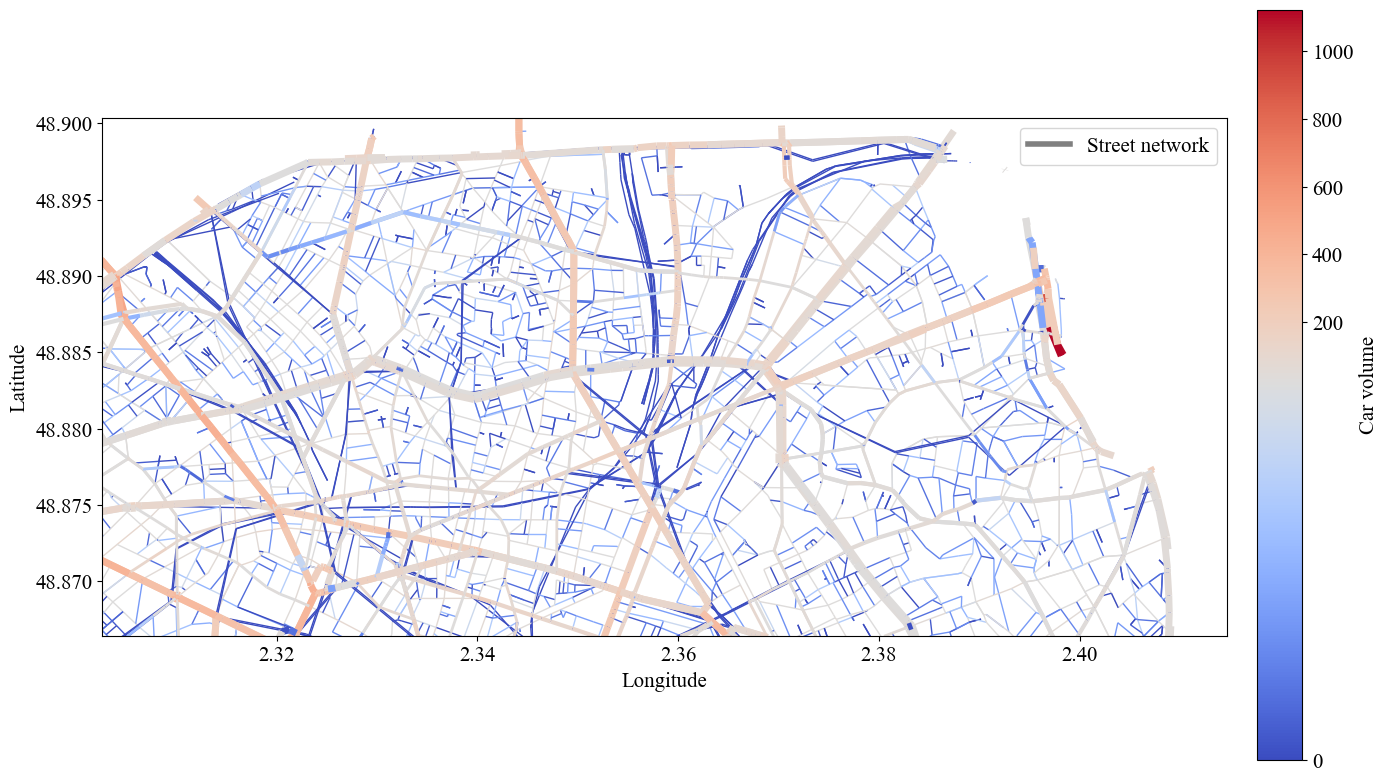

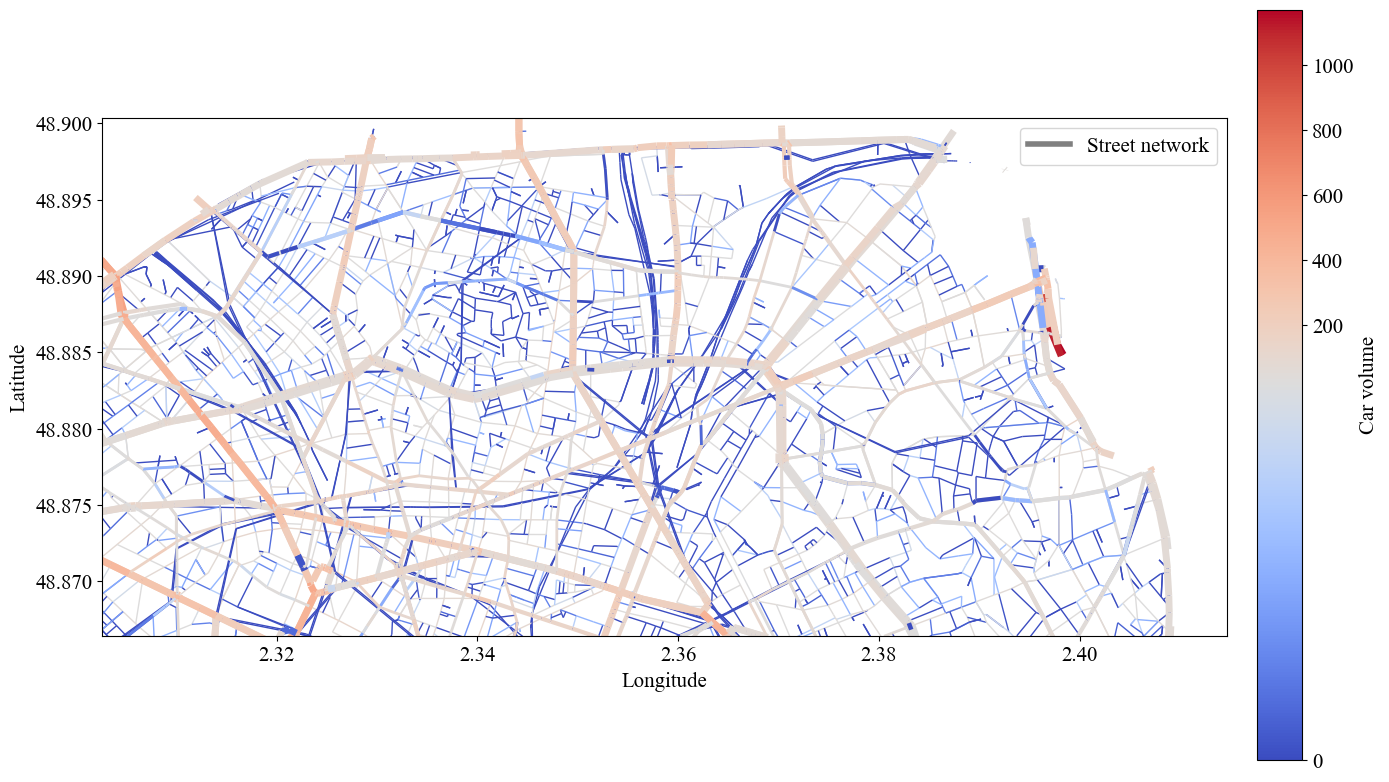

In [6]:
plot_combined_output(gdf_input= gdf_pop_1pct_within_boundary, column_to_plot="vol_car", save_it= False, use_fixed_norm=False, fixed_norm_max=100, fixed_norm_mid_point=20, identifier_string= "basecase_1pct_do_not_use_norm")
plot_combined_output(gdf_input= gdf_pop_1pm_within_boundary, column_to_plot="vol_car_times_10", save_it=False, use_fixed_norm=False, fixed_norm_max=100, fixed_norm_mid_point=20, identifier_string="basecase_1pm_do_not_use_norm")

In [7]:
gdf_pop_1pct_within_boundary.total_bounds

array([ 2.2526634 , 48.81641444,  2.4146692 , 48.90035054])

In [9]:
gdf_pop_1pct_within_boundary.total_bounds[0] - 0.05

2.2026633999999996